In [30]:
import glob
import numpy
import matplotlib.pyplot as plt
import pandas as pd

In [59]:
use_one_csv = False
one_csv_path = "../results/vary_sigma.csv"
multi_csv_paths = "../results/vary-sigma-*.csv"

In [32]:
if use_one_csv: # if loading from one csv
    df = pd.read_csv(one_csv_path)
else: # if loading from multiple csvs
    df: pd.DataFrame = pd.DataFrame()
    found_files = []
    for file in glob.glob(multi_csv_paths):
        found_files.append(file) 
        df_it = pd.read_csv(file)
        df = df.append(df_it)

In [33]:
print("files: {}".format(found_files))
found_ds = list(df["dataset"].unique())
found_sigmas = list(df["facet_sd"].unique())
print("datasets: {}".format(found_ds))
print("sigmas: {}".format(found_sigmas))

files: ['vary_sigma_it0.csv', 'vary_sigma_it1.csv', 'vary_sigma_it2.csv', 'vary_sigma_it3.csv', 'vary_sigma_it4.csv', 'vary_sigma_it5.csv', 'vary_sigma_it6.csv', 'vary_sigma_it7.csv', 'vary_sigma_it8.csv', 'vary_sigma_it9.csv']
datasets: ['adult', 'compas', 'credit']
sigmas: [0.0001, 0.005, 0.001, 0.05, 0.1, 0.12, 0.2, 0.25]


In [34]:
df = df.groupby(["dataset", "explainer", "facet_sd"]).mean()
df.head(20)

n_trees  max_depth  iteration  accuracy  \
dataset explainer  facet_sd                                            
adult   FACETIndex 0.0001       10.0        5.0      4.500  0.841614   
                   0.0010       10.0        5.0      4.500  0.841614   
                   0.0050       10.0        5.0      4.500  0.841614   
                   0.0500       10.0        5.0      4.500  0.841614   
                   0.1000       10.0        5.0      4.500  0.841614   
                   0.1200       10.0        5.0      4.500  0.841614   
                   0.2000       10.0        5.0      4.625  0.841708   
                   0.2500       10.0        5.0      5.600  0.841349   
compas  FACETIndex 0.0001       10.0        5.0      4.500  0.666667   
                   0.0010       10.0        5.0      4.500  0.666667   
                   0.0050       10.0        5.0      4.500  0.666667   
                   0.0500       10.0        5.0      4.500  0.666667   
                   0.1000       10.0        5.0      4.500  0.666667   
                   0.1200       10.0        5.0      4.500  0.666667   
                   0.2000       10.0        5.0      4.625  0.665601   
                   0.2500       10.0        5.0      5.600  0.660795   
credit  FACETIndex 0.0001       10.0        5.0      4.500  0.806110   
                   0.0010       10.0        5.0      4.500  0.806110   
                   0.0050       10.0        5.0      4.500  0.806110   
                   0.0500       10.0        5.0      4.500  0.806110   

                             precision    recall        f1  per_valid  \
dataset explainer  facet_sd                                             
adult   FACETIndex 0.0001     0.807543  0.474376  0.596301    1.00000   
                   0.0010     0.807543  0.474376  0.596301    1.00000   
                   0.0050     0.807543  0.474376  0.596301    1.00000   
                   0.0500     0.807543  0.474376  0.596301    1.00000   
                   0.1000     0.807543  0.474376  0.596301    1.00000   
                   0.1200     0.807543  0.474376  0.596301    1.00000   
                   0.2000     0.806705  0.473189  0.594830    0.91875   
                   0.2500     0.815537  0.460138  0.586221    0.86000   
compas  FACETIndex 0.0001     0.659164  0.601606  0.628645    1.00000   
                   0.0010     0.659164  0.601606  0.628645    1.00000   
                   0.0050     0.659164  0.601606  0.628645    1.00000   
                   0.0500     0.659164  0.601606  0.628645    1.00000   
                   0.1000     0.659164  0.601606  0.628645    1.00000   
                   0.1200     0.659164  0.601606  0.628645    1.00000   
                   0.2000     0.661723  0.599919  0.628879    1.00000   
                   0.2500     0.655141  0.600846  0.626544    1.00000   
credit  FACETIndex 0.0001     0.828076  0.948722  0.884284    1.00000   
                   0.0010     0.828076  0.948722  0.884284    1.00000   
                   0.0050     0.828076  0.948722  0.884284    1.00000   
                   0.0500     0.828076  0.948722  0.884284    1.00000   

                             avg_dist  avg_manhattan  avg_length  prep_time  \
dataset explainer  facet_sd                                                   
adult   FACETIndex 0.0001    0.349074       0.501647    2.105000   2.896519   
                   0.0010    0.349772       0.501757    2.075000   2.883853   
                   0.0050    0.342342       0.491593    2.095000   2.909180   
                   0.0500    0.240412       0.326895    1.785000   3.196901   
                   0.1000    0.173576       0.226462    1.675000   3.231624   
                   0.1200    0.168691       0.218804    1.670000   3.253912   
                   0.2000    0.120645       0.151798    1.612418   3.515512   
                   0.2500    0.114455       0.141626    1.528947   3.916683   
compas  FACETIndex 0.0001    0.144259       0.1

[0.8842844616906577,
 0.8842844616906577,
 0.8842844616906577,
 0.8842844616906577,
 0.8842844616906577,
 0.8842844616906577,
 0.8838738993863602,
 0.8828381320860721]

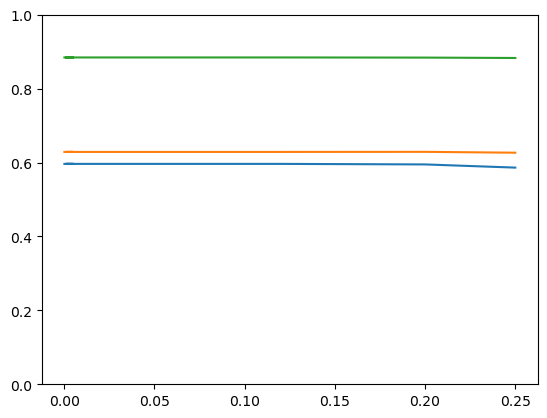

In [57]:
plt.figure()
for ds in found_ds:
    f1s = list(df.loc[ds, "FACETIndex", found_sigmas]["f1"])
    plt.plot(found_sigmas, f1s)
plt.ylim([0, 1])
plt.show()